# Laboratorio di simulazione numerica

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import string
from mpl_toolkits.mplot3d import Axes3D

### Exercise 05.1

In this exercise I sampled the probability distribution of the position of an electron in two eigenstates of a hydrogen atom, using the Metropolis algorithm.
To propose the next step in the chain I used a uniform transition probability, drawing the new position from a cube (centred on the previous position) whose edge length was tuned in order to get an acceptance ratio of roughly 1/2:
* for the 1s eigenstate, I set an edge length of was 2.44 Bohr radii, which gave an acceptance ratio of 0.49904 after 100 000 steps.
* for the 2p eigenstate, an edge length of 5.8 Bohr radii gave a ratio of 0.50874 after the same number of steps.

##### Estimation of the equilibration time
Plotting the radius at each step sampled by the Metropolis algorithm, starting from the point farther from the origin, I make a guess at the equilibration time.
The data in this plot can be generated by running `./exercise05_raw far`.

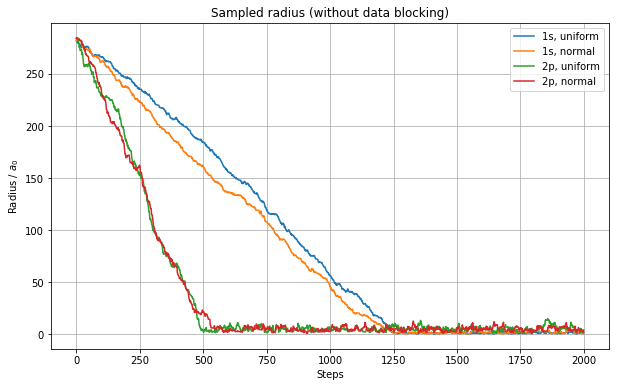

In [52]:
radius_raw = np.loadtxt("far/radius_raw.dat", skiprows = 1)

plt.figure(figsize = (10, 6))
plt.plot(
    radius_raw,
)
plt.xlabel("Steps")
plt.ylabel(r"Radius / $a_0$")
plt.title("Sampled radius (without data blocking)")
plt.grid(True)
plt.legend(["1s, uniform", "1s, normal", "2p, uniform", "2p, normal"])
plt.show()

It is very clear from this last plot that the equilibration time for the 2p sampling is around 600 steps, while for the 1s sampling it is around 1250 steps.
I take this as a worst-case scenario, and apply this results to the sampled radius starting from the point closer to the origin: the algorithm will *surely* be equilibrated after these amounts of steps.

#### 1s eigenstate
The following plot shows the distribution in space of the sampled points.

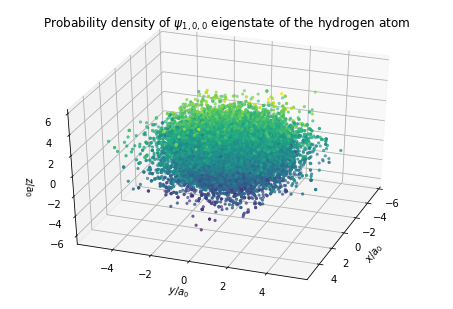

In [2]:
x, y, z = np.loadtxt("1s_sampled_points_uniform.dat", unpack = True)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x/a_0$")
ax.set_ylabel(r"$y/a_0$")
ax.set_zlabel(r"$z/a_0$")
plt.title(r"Probability density of $\psi_{1,0,0}$ eigenstate of the hydrogen atom")
ax.view_init(35, 20)
plt.show()

The following plot shows the progressive value of the average radius, and its standard deviation, of the above results, using a blocking technique, dividing the data in 100 blocks.

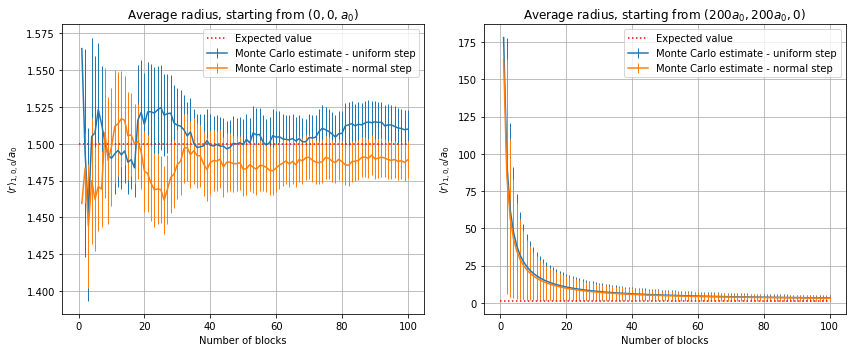

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

radius_1s_far = np.loadtxt("close/1s_radius_avg.dat", unpack = True, skiprows = 1)

axes[0].errorbar(
    range(1, len(radius_1s_far[0]) + 1),
    radius_1s_far[0],
    yerr = radius_1s_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[0].errorbar(
    range(1, len(radius_1s_far[2]) + 1),
    radius_1s_far[2],
    yerr = radius_1s_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[0].hlines(
    3/2,
    0,
    len(radius_1s_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[0].set_title(r"Average radius, starting from $(0,0,a_0)$")
axes[0].set_ylabel(r"$\langle r\rangle_{1,0,0}/a_0$")
axes[0].set_xlabel("Number of blocks")
axes[0].legend()
axes[0].grid(True)

radius_1s_far = np.loadtxt("far/1s_radius_avg.dat", unpack = True, skiprows = 1)

axes[1].errorbar(
    range(1, len(radius_1s_far[0]) + 1),
    radius_1s_far[0],
    yerr = radius_1s_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[1].errorbar(
    range(1, len(radius_1s_far[2]) + 1),
    radius_1s_far[2],
    yerr = radius_1s_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[1].hlines(
    3/2,
    0,
    len(radius_1s_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[1].set_title(r"Average radius, starting from $(200a_0, 200a_0, 0)$")
axes[1].set_ylabel(r"$\langle r\rangle_{1,0,0}/a_0$")
axes[1].set_xlabel("Number of blocks")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()
plt.show()

#### 2p eigenstate
The following plots are as the two above, but they refer to the 2p eigenstate.

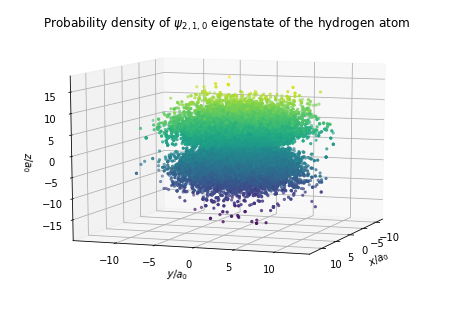

In [4]:
x, y, z = np.loadtxt("2p_sampled_points_uniform.dat", unpack = True)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, c = z, marker = ".")
ax.set_xlabel(r"$x/a_0$")
ax.set_ylabel(r"$y/a_0$")
ax.set_zlabel(r"$z/a_0$")
plt.title(r"Probability density of $\psi_{2,1,0}$ eigenstate of the hydrogen atom")
ax.view_init(10, 20)
plt.show()

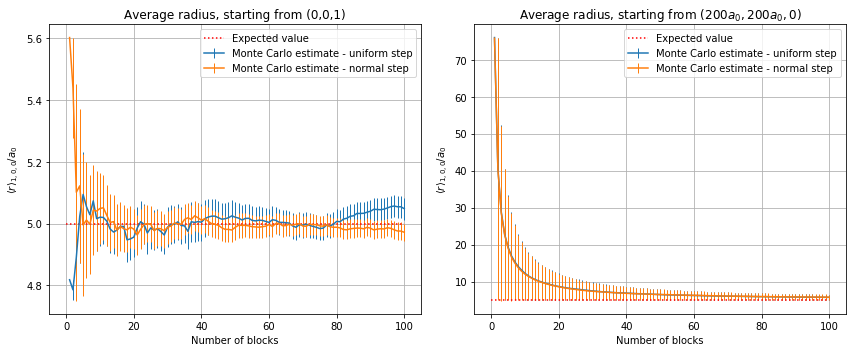

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

radius_2p_far = np.loadtxt("close/2p_radius_avg.dat", unpack = True, skiprows = 1)

axes[0].errorbar(
    range(1, len(radius_2p_far[0]) + 1),
    radius_2p_far[0],
    yerr = radius_2p_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[0].errorbar(
    range(1, len(radius_2p_far[2]) + 1),
    radius_2p_far[2],
    yerr = radius_2p_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[0].hlines(
    5,
    0,
    len(radius_2p_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[0].set_title(r"Average radius, starting from $(0,0,a_0)$")
axes[0].set_ylabel(r"$\langle r\rangle_{1,0,0}/a_0$")
axes[0].set_xlabel("Number of blocks")
axes[0].legend()
axes[0].grid(True)

radius_2p_far = np.loadtxt("far/2p_radius_avg.dat", unpack = True, skiprows = 1)

axes[1].errorbar(
    range(1, len(radius_2p_far[0]) + 1),
    radius_2p_far[0],
    yerr = radius_2p_far[1],
    elinewidth = 1,
    label = "Monte Carlo estimate - uniform step"
)
axes[1].errorbar(
    range(1, len(radius_2p_far[2]) + 1),
    radius_2p_far[2],
    yerr = radius_2p_far[3],
    elinewidth = 1,
    label = "Monte Carlo estimate - normal step"
)
axes[1].hlines(
    5,
    0,
    len(radius_2p_far[0]),
    colors = "red",
    linestyle = "dotted",
    label = "Expected value"
)
axes[1].set_title(r"Average radius, starting from $(200a_0, 200a_0, 0)$")
axes[1].set_ylabel(r"$\langle r\rangle_{1,0,0}/a_0$")
axes[1].set_xlabel("Number of blocks")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()
plt.show()